In [161]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt


from generator import Generator
from BaseColor import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [162]:
def show_img(img, title="",cmap=None):
    plt.imshow(img.astype("uint8"),cmap=cmap)
    plt.axis('off')
    plt.title(title)
    plt.show() # prikaz slike

In [163]:
G = Generator()
G = G.to(device)
G.eval()  

def broj_parametara(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Broj parametara Generatora:", broj_parametara(G))


Broj parametara Generatora: 39316459


## Ucitavanje slike i preprocessing - testiranje funkcija - nebitno

In [164]:
img = load_img("imgs\\n01818515_67.JPEG")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


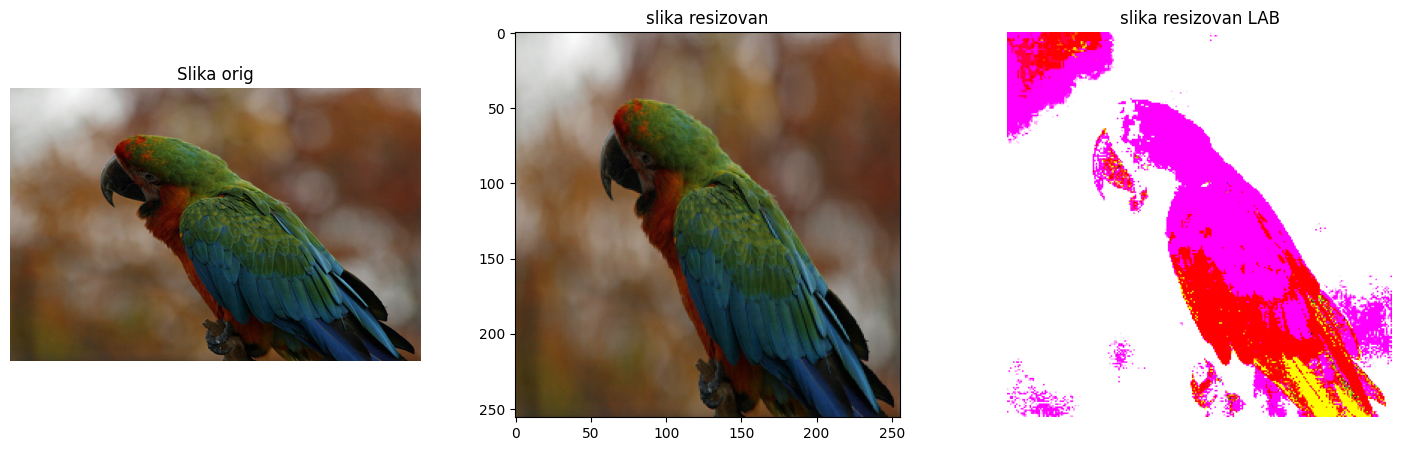

In [165]:
img_rgb_rs = resize_img(img, HW=(256,256), resample=4) #resize na 256x256 kvalitetnije
img_lab = color.rgb2lab(img_rgb_rs)  #konv iz RGB u LAB
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Slika orig')

axes[1].imshow(img_rgb_rs, cmap='gray')  
axes[1].set_title('slika resizovan')

axes[2].imshow(img_lab)
axes[2].axis('off')
axes[2].set_title('slika resizovan LAB')

plt.show()

## Izdvajanje kanala i prikaz L kanala slike - nebitno

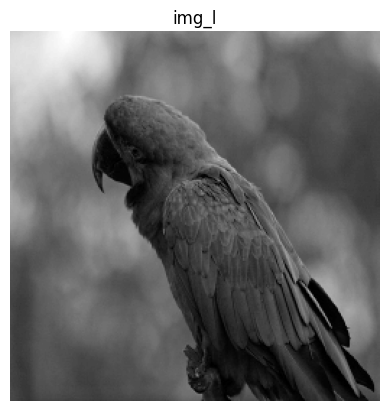

(0.0, 98.61813872854867, -39.799309566548246, 55.652964271020124)

In [166]:
img_l = img_lab[:, :, 0]  # L kanal -0 do 100
img_ab = img_lab[:, :, 1:3]   #a b kanali - -127 do 127
show_img(img_l, "img_l", cmap='gray')
img_l.min(), img_l.max(), img_ab.min(), img_ab.max()

### Rekonstrukcija kanala u jednistvenu sliku - nebitno
Sabiraju se prethodno izdvojeni kanali ab i L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'slika rekonstrusana l+ab -> rgb')

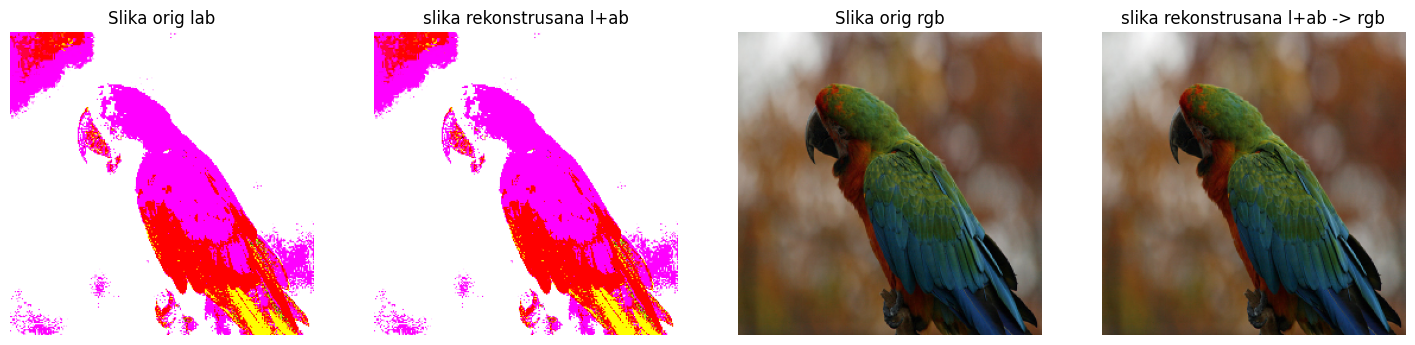

In [167]:
img_l = img_l[:, :, None]  # dodavanje trece dimenziju za nadovezivanje kanala
img_l_exp = img_l[:, :,]  # (H,W,1)
img_lab_reconstructed = np.concatenate((img_l_exp, img_ab), axis=2)  # (H,W,3)
img_rgb_reconstructed = color.lab2rgb(img_lab_reconstructed)
fig, axes = plt.subplots(1, 4, figsize=(18, 5)) 

axes[0].imshow(img_lab)
axes[0].axis('off')
axes[0].set_title('Slika orig lab')

axes[1].imshow(img_lab_reconstructed, cmap='gray')  
axes[1].axis('off')
axes[1].set_title('slika rekonstrusana l+ab')

axes[2].imshow(img_rgb_rs)
axes[2].axis('off')
axes[2].set_title('Slika orig rgb')

axes[3].imshow(img_rgb_reconstructed, cmap='gray')  
axes[3].axis('off')
axes[3].set_title('slika rekonstrusana l+ab -> rgb')


In [168]:
img_rgb_rs.min(), img_rgb_rs.max(), img_lab_reconstructed.min(), img_lab_reconstructed.max()


(0, 251, -39.799309566548246, 98.61813872854867)

## Testiranje generatora


In [169]:
def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	1 x 1 x H_orig x W_orig
	# out_ab 		1 x 2 x H x W

	HW_orig = tens_orig_l.shape[2:]
	HW = out_ab.shape[2:]

	# call resize function if needed
	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))


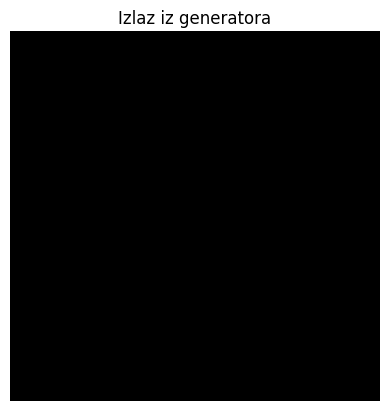

Oblik izlaza iz generatora (AB kanali): torch.Size([1, 2, 256, 256])
Min vrednost izlaza: -0.031163617968559265
Max vrednost izlaza: 0.36956456303596497


In [170]:
img_l = img_lab[:, :, 0]  # L kanal -0 do 100
L_tensor = torch.tensor(img_l, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # # 1 x 1 x H x W 

with torch.no_grad():
    ab_output = G(L_tensor) # 1 x 2 x H x W

out_img = postprocess_tens(L_tensor, ab_output) #  1 x 3 x H x W pa u 3 x H x W pa u H x W x 3
show_img(out_img, "Izlaz iz generatora")
print("Oblik izlaza iz generatora (AB kanali):", ab_output.shape)
print("Min vrednost izlaza:", ab_output.min().item())
print("Max vrednost izlaza:", ab_output.max().item())


In [171]:
ab_output.shape, L_tensor.shape, out_img.shape

(torch.Size([1, 2, 256, 256]), torch.Size([1, 1, 256, 256]), (256, 256, 3))

In [172]:
out_img

array([[[0.77107286, 0.7700069 , 0.7674001 ],
        [0.772256  , 0.77118963, 0.76858205],
        [0.7722555 , 0.77118975, 0.76858217],
        ...,
        [0.5637686 , 0.5627726 , 0.56030893],
        [0.56938183, 0.56838477, 0.56591743],
        [0.56955457, 0.5685575 , 0.56609   ]],

       [[0.78284043, 0.78177124, 0.77915734],
        [0.7887616 , 0.7876909 , 0.7850735 ],
        [0.7918668 , 0.790796  , 0.7881767 ],
        ...,
        [0.55736923, 0.5563752 , 0.55391645],
        [0.5675856 , 0.5665891 , 0.56412303],
        [0.5752733 , 0.57427424, 0.5718024 ]],

       [[0.7867627 , 0.78569275, 0.783077  ],
        [0.79460776, 0.7935356 , 0.79091537],
        [0.7985297 , 0.7974572 , 0.7948346 ],
        ...,
        [0.5576286 , 0.55663455, 0.5541756 ],
        [0.5624739 , 0.56147915, 0.55901706],
        [0.5674333 , 0.5664368 , 0.563971  ]],

       ...,

       [[0.2597124 , 0.25884715, 0.25669017],
        [0.25693038, 0.25606674, 0.25391352],
        [0.25557548, 0

In [173]:
out_img

array([[[0.77107286, 0.7700069 , 0.7674001 ],
        [0.772256  , 0.77118963, 0.76858205],
        [0.7722555 , 0.77118975, 0.76858217],
        ...,
        [0.5637686 , 0.5627726 , 0.56030893],
        [0.56938183, 0.56838477, 0.56591743],
        [0.56955457, 0.5685575 , 0.56609   ]],

       [[0.78284043, 0.78177124, 0.77915734],
        [0.7887616 , 0.7876909 , 0.7850735 ],
        [0.7918668 , 0.790796  , 0.7881767 ],
        ...,
        [0.55736923, 0.5563752 , 0.55391645],
        [0.5675856 , 0.5665891 , 0.56412303],
        [0.5752733 , 0.57427424, 0.5718024 ]],

       [[0.7867627 , 0.78569275, 0.783077  ],
        [0.79460776, 0.7935356 , 0.79091537],
        [0.7985297 , 0.7974572 , 0.7948346 ],
        ...,
        [0.5576286 , 0.55663455, 0.5541756 ],
        [0.5624739 , 0.56147915, 0.55901706],
        [0.5674333 , 0.5664368 , 0.563971  ]],

       ...,

       [[0.2597124 , 0.25884715, 0.25669017],
        [0.25693038, 0.25606674, 0.25391352],
        [0.25557548, 0